In [ ]:
!pip install -qU pinecone-client cohere

In [ ]:
!pip install -qU evaluate rouge_score bert_score

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForTokenClassification
import torch
import re
import nlu
from evaluate import load

In [ ]:
from pinecone import Pinecone, ServerlessSpec
import cohere
import os
import time
import pandas as pd



sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [ ]:
papers = pd.concat([pd.read_csv("/content/alzheimer_biomarker_1000.csv"), pd.read_csv("/content/alzheimer_biomarker_2000.csv")]).dropna(subset=["fulltext"]).reset_index(drop=True).astype(str)

In [ ]:
def authenticate_co_pc():
    global pc
    global co
    co = cohere.Client(COHERE_API_KEY)
    pc = Pinecone(PINECONE_API_KEY)

    return

def retrieve_similar_articles(keyword: str, k: int = 5):
    index_name = "scientific-papers"
    index = pc.Index(index_name)
    print(f"Opened index {index_name}")

    query_embedding = co.embed(
        texts=[keyword],
        model="embed-english-v3.0",
        input_type="search_query"
    ).embeddings

    ### DOCUMENTATION CODE https://docs.pinecone.io/guides/get-started/quickstart
    results = index.query(vector=query_embedding, top_k=k, include_metadata=True)
    ### END OF DOCUMENTATION CODE

    similar_articles = []
    for match in results['matches']:
        similar_articles.append({
            "paper_id": match['id'],
            "pmcid": match["metadata"]["paper_pmic"],
            "pmid": match["metadata"]["paper_pmid"],
            "title": match['metadata']['title'],
            "score": match['score']
        })

    return similar_articles


In [ ]:
authenticate_co_pc()

In [ ]:

def load_model_and_tokenizer(model_name):
    ### DOCUMENTATION CODE https://huggingface.co/docs/transformers/en/model_doc/auto
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    ### END OF DOC CODE
    return model, tokenizer


In [ ]:
def generate_summary(model, tokenizer, text, max_length=150, min_length=50):
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs, max_length=max_length, min_length=min_length, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return summary

In [ ]:
t5_model, t5_tokenizer = load_model_and_tokenizer("t5-base")
bart_model, bart_tokenizer = load_model_and_tokenizer("facebook/bart-large-cnn")
pegasus_model, pegasus_tokenizer = load_model_and_tokenizer("sshleifer/distill-pegasus-xsum-16-4")

In [ ]:
rouge = load("rouge")
bertscore = load("bertscore")

In [ ]:
def compare_summaries(text, reference):
    t5_summary = generate_summary(t5_model, t5_tokenizer, text)
    bart_summary = generate_summary(bart_model, bart_tokenizer, text)
    pegasus_summary = generate_summary(pegasus_model, pegasus_tokenizer, text)
    scores = {}

    print("T5 Summary:")
    print(t5_summary)
    t5_score = bertscore.compute(predictions=[t5_summary], references=[reference],lang="en")
    print("T5 Score: ", t5_score)
    scores["t5_score"] = t5_score
    print("\nBART Summary:")
    print(bart_summary)
    bart_score = bertscore.compute(predictions=[bart_summary], references=[reference],lang="en")
    print("BART Score: ", bart_score)
    scores["bart_score"] = bart_score
    print("\nPEGASUS Summary:")
    print(pegasus_summary)
    peg_score = bertscore.compute(predictions=[pegasus_summary], references=[reference],lang="en")
    print("Pegasus Score: ", peg_score)
    scores["peg_score"] = peg_score

    return scores

In [ ]:
def summarize_top_papers(keyword):
    top_papers = retrieve_similar_articles(keyword)
    scores = []
    for paper in top_papers:
        paper = papers[papers["pmcid"] == paper["pmcid"]]

        print(f"\nSummarizing paper: {paper['title'].iloc[0]}")
        score = compare_summaries(paper['fulltext'].iloc[0], paper["abstract"].iloc[0])
        scores.append(score)
    return scores

In [ ]:
keyword = "Alzheimer's Disease Biomarkers"
scores = summarize_top_papers(keyword)

Opened index scientific-papers

Summarizing paper: From Organotypic Mouse Brain Slices to Human Alzheimer Plasma Biomarkers: A Focus on Microglia
T5 Summary:
there is widespread agreement on four well-defined and validated cerebrospinal fluid (CSF) biomarkers in AD: A-42, A-40, total tau, and phosphorylated (phospho-)tau-181. we hypothesize that plasma from AD patients may contain or lack factors compared to healthy subjects. we utilize mass spectrometry on the most promising samples to identify new potential biomarkers.
T5 Score:  {'precision': [0.8723703622817993], 'recall': [0.8229666352272034], 'f1': [0.8469486236572266], 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.44.2)'}

BART Summary:
Clinical evaluation remains the most frequently used method for diagnosing Alzheimer’s disease (AD) Early diagnosis is thought to facilitate treatment of the disease before it progresses significantly. For diagnosing AD or its early forms, such as mild cognitive impairment (MCI

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
models = ['T5', 'BART', 'PEG']
metrics = ['precision', 'recall', 'f1']
x = np.arange(len(scores))
width = 0.25

In [ ]:
# scores

In [ ]:
for i,model in enumerate(models):
    print([r for r in scores])

[{'t5_score': {'precision': [0.8723703622817993], 'recall': [0.8229666352272034], 'f1': [0.8469486236572266], 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.44.2)'}, 'bart_score': {'precision': [0.8717445731163025], 'recall': [0.8292675614356995], 'f1': [0.8499757051467896], 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.44.2)'}, 'peg_score': {'precision': [0.8551005721092224], 'recall': [0.8001255393028259], 'f1': [0.8267001509666443], 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.44.2)'}}, {'t5_score': {'precision': [0.8705866932868958], 'recall': [0.7918724417686462], 'f1': [0.829366147518158], 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.44.2)'}, 'bart_score': {'precision': [0.8496330976486206], 'recall': [0.7928899526596069], 'f1': [0.8202813863754272], 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.44.2)'}, 'peg_score': {'precision': [0.8824245929718018], 'recall': [0.7937456369400024], '

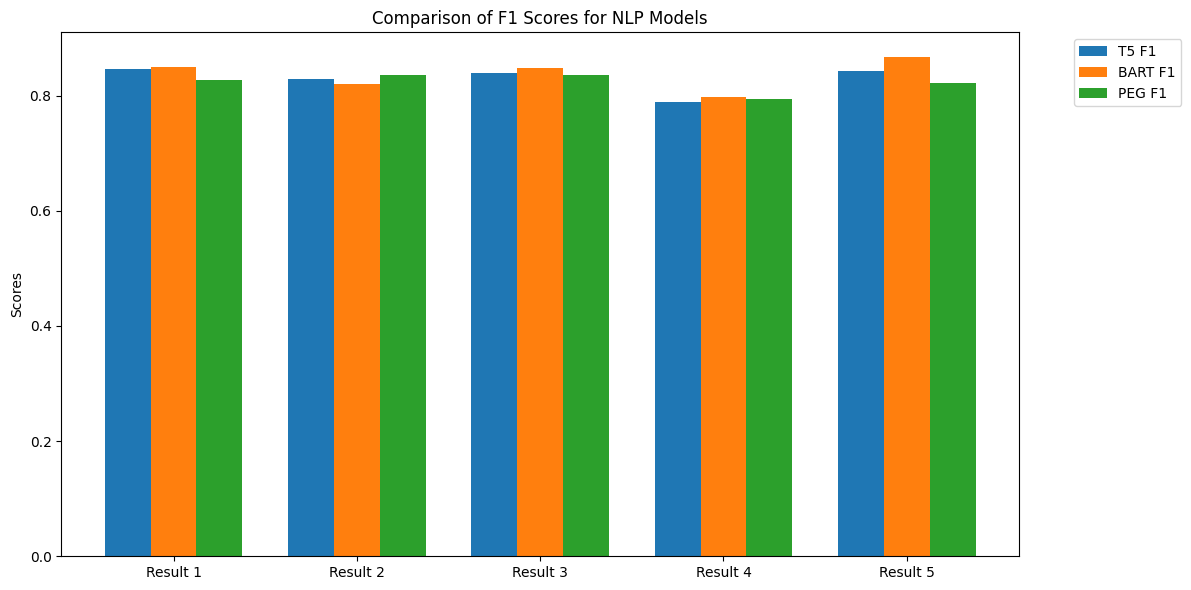

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

for i, model in enumerate(models):
    result = [r[f'{model.lower()}_score'] for r in scores]
    ax.bar(x + i*width, [s['f1'][0] for s in result],width, label=f'{model} F1')

ax.set_ylabel('Scores')
ax.set_title('Comparison of F1 Scores for NLP Models')
ax.set_xticks(x + width)
ax.set_xticklabels([f'Result {i+1}' for i in range(len(scores))])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

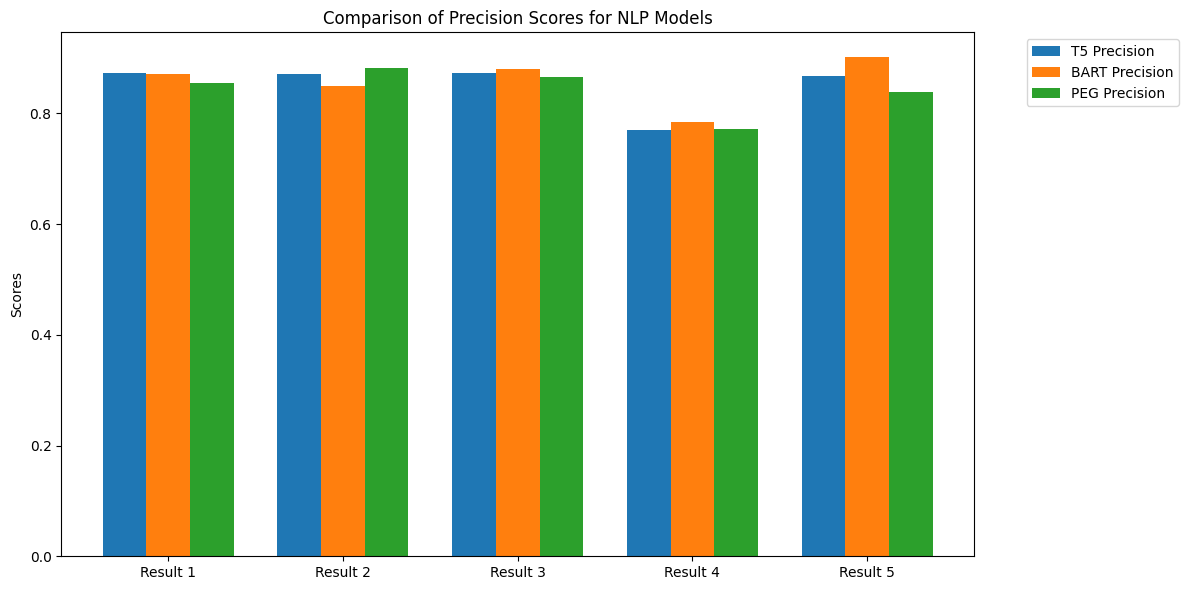

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

for i, model in enumerate(models):
    result = [r[f'{model.lower()}_score'] for r in scores]
    ax.bar(x + i*width, [s['precision'][0] for s in result], width, label=f'{model} Precision')

ax.set_ylabel('Scores')
ax.set_title('Comparison of Precision Scores for NLP Models')
ax.set_xticks(x + width)
ax.set_xticklabels([f'Result {i+1}' for i in range(len(scores))])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

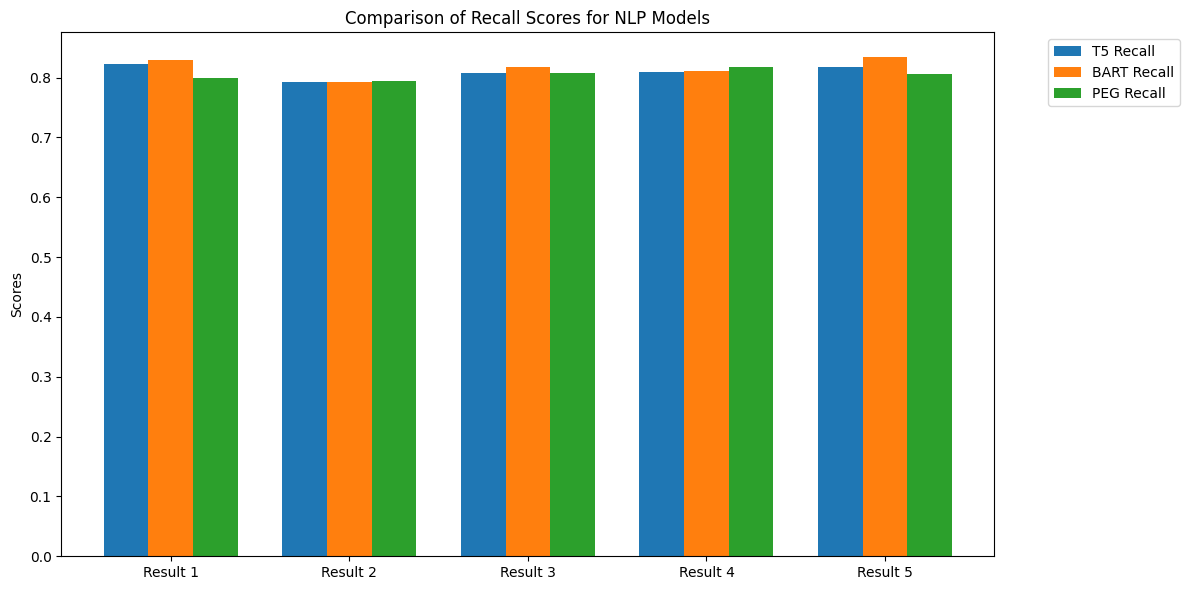

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

for i, model in enumerate(models):
    result = [r[f'{model.lower()}_score'] for r in scores]
    ax.bar(x + i*width, [s['recall'][0] for s in result], width, label=f'{model} Recall')

ax.set_ylabel('Scores')
ax.set_title('Comparison of Recall Scores for NLP Models')
ax.set_xticks(x + width)
ax.set_xticklabels([f'Result {i+1}' for i in range(len(scores))])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

NER model

In [ ]:
def load_ner_model_and_tokenizer(model_name):
    ### DOCUMENTATION CODE https://huggingface.co/docs/transformers/en/model_doc/auto
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForTokenClassification.from_pretrained(model_name)
    ### END OF DOC CODE
    return model, tokenizer

In [ ]:
### MODEL FROM https://huggingface.co/alvaroalon2/biobert_genetic_ner
biobert_model, biobert_tokenizer = load_ner_model_and_tokenizer("alvaroalon2/biobert_genetic_ner")


tokenizer_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at monologg/biobert_v1.1_pubmed and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/431M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/417 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/706k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
def perform_ner(model, tokenizer, text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=2)

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    labels = [model.config.id2label[t.item()] for t in predictions[0]]

    entities = []
    current_entity = ""
    current_label = ""

    for token, label in zip(tokens, labels):
        if label.startswith("B-"):
            if current_entity:
                entities.append((current_entity.strip(), current_label))
            current_entity = token.replace("#", "")
            current_label = label[2:]
        elif label.startswith("I-"):
            current_entity += " " + token.replace("#", "")
        else:
            if current_entity:
                entities.append((current_entity.strip(), current_label))
            current_entity = ""
            current_label = ""

    if current_entity:
        entities.append((current_entity.strip(), current_label))

    for i, (e, l) in enumerate(entities):
        entities[i] = (e.replace(" ", ""), l)


    return entities

In [ ]:
keyword = "Alzheimer's Disease Biomarkers"

top_papers = retrieve_similar_articles(keyword)

Opened index scientific-papers


In [ ]:
for i, paper in enumerate(top_papers, 1):
    data = papers[papers["pmcid"] == paper["pmcid"]].iloc[0]
    print(f"\nPaper {i}: {data['title']}")
    print("Abstract:")
    print(data['abstract'])
    print("\nNER Results:")
    results = perform_ner(model=biobert_model, tokenizer=biobert_tokenizer, text=data['fulltext'])
    for entity, label in results:
        print(f"- {entity} ({label})")


Paper 1: From Organotypic Mouse Brain Slices to Human Alzheimer Plasma Biomarkers: A Focus on Microglia
Abstract:
Alzheimer’s disease is a severe neurodegenerative disorder, and the discovery of biomarkers is crucial for early diagnosis. While the analysis of biomarkers in cerebrospinal fluid is well accepted, there are currently no blood biomarkers available. Our research focuses on identifying novel plasma biomarkers for Alzheimer’s disease. To achieve this, we employed a technique that involves coupling human plasma to mouse organotypic brain slices via microcontact prints. After culturing for two weeks, we assessed Iba1-immunopositive microglia on these microcontact prints. We hypothesized that plasma from Alzheimer’s patients contains factors that affect microglial migration. Our data indicated that plasma from Alzheimer’s patients significantly inhibited the migration of round Iba1-immunoreactive microglia (13 ± 3,  n  = 24,  p  = 0.01) compared to healthy controls (50 ± 16,  n 